# Vapor Plume Expansion

Erik Davies - 03/05/2020

This script loads in an eos and calculates a decompression isentrope from a given shock
state.

This code also takes an initial volume of shocked material that will
expand as a vapor plume and calculates a cooling rate at different
volumes. (spherical plume)

Order of operations
1. Load in isentrope
2. Calculate Planar expansion velocity - assume this is close to spherical
    expansion velocity
3. Calculate time profiles of P, rho, T and total time to ambient "pressure"
     or system closure (below the triple point)
4. Calculate MFP (skin depth) of the expanding cloud
5. Radiative cooling time for each "timestep" (when does radiative
    cooling become dominant for this initial volume)

In [1]:
#User parameter inputs
#Simple user inputs, nothing else should need changing
#Enotropy value of the release isentrope
S_cho=4000 #J/K/kg

#Assume spherical expansion for volume
#Input initial compressed radius
ri=1 #km
tp=5.2 #Pa, typical for silicates, change if different material

#Set up array size for later on vapor fraction calculation
size=100000


In [2]:
#Check and record versions
import platform
print('python version: ',platform.python_version())
del platform
import matplotlib
print('matplotlib version: ', matplotlib.__version__)
del matplotlib
import numpy
print('numpy version: ', numpy.__version__)
del numpy
import scipy
print('scipy version: ', scipy.__version__)
del scipy
import pandas
print('pandas version: ', pandas.__version__)
del pandas

python version:  3.5.2
matplotlib version:  3.0.3
numpy version:  1.18.1
scipy version:  1.4.1
pandas version:  0.24.2


In [3]:
# this prevents some error messages for inline plotting in a jupyter notebook
%matplotlib inline 
# import python libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy
import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import colormaps as local_cmaps
import subprocess
import pandas as pd
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import scipy as sp
import statistics as stat
from matplotlib import rc
import eostable as eos
#

In [4]:

########Plot Parameters begin############3
#These control font size in plots.
params = {'legend.fontsize': 12,
         'axes.labelsize': 12,
         'axes.titlesize':12,
         'xtick.labelsize':12,
         'ytick.labelsize':10}
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rcParams.update(params)
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['axes.linewidth']= 1

plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['lines.dashed_pattern'] = [6, 6]
plt.rcParams['lines.dashdot_pattern'] = [3, 5, 1, 5]
plt.rcParams['lines.dotted_pattern'] = [1, 3]
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['lines.scale_dashes'] = False
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = None
plt.rcParams['legend.edgecolor'] = 'inherit'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='Times New Roman'
plt.rcParams["figure.figsize"] = (5,4)
plt.rcParams["patch.force_edgecolor"] = True

########Plot Parameters finish############3


In [5]:
#Load in model

MODELNAME = 'Forsterite-ANEOS-SLVTv1.0G1'
# read EOS table      
forstEOS = eos.extGADtable()
forstEOS.readStdGadget('NEW-GADGET-STD-NOTENSION.TXT') # reads P-V-T-S-U-cs
forsthug = eos.EOShugoniot()
forsthug.T=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[0]) # K
forsthug.rho=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[1]) * 1000 # To kg/m^3
forsthug.P=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[2]) # Gpa
forsthug.U=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[3]) # MJ/kg
forsthug.S=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[4]) *(10**6) # J/K/kg
forsthug.up=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[5]) #km/s
forsthug.us=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[6]) #km/s



#Units are in CGS so replace with SI
#S is in erg/K/g
forstEOS.S=forstEOS.S *(10**(-4)) #J/K/kg
# rho is g/cm^3
forstEOS.rho=forstEOS.rho *(10**(3)) #kg/m^3
#P is dynes/cm2
forstEOS.P=forstEOS.P *(10**(-10))#GPa
#T is K, do nothing
#Cs, sound sped is cm/s
forstEOS.cs=forstEOS.cs *(10**(-5)) 

In [6]:
#More model stuff - taken from forsterite_aneos.ipynb
# ====>>>>>> YOU NEED TO MAKE SURE THESE VALUES MATCH ANEOS.INPUT  <<<<=====
MODELNAME = 'Forsterite-ANEOS-SLVTv1.0G1'
# Header information must all be compatible with float format
MATID = 1.0        # MATID number
DATE = 190802.     # Date as a single 6-digit number YYMMDD
VERSION = 0.1      # ANEOS Parameters Version number
FMN = 70.          # Formula weight in atomic numbers for Mg2SiO4
FMW = 140.691      # Formula molecular weight (g/cm3) for Mg2SiO4
# The following define the default initial state for material in the 201 table
R0REF   = 3.22     # g/cm3 *** R0REF is inserted into the density array
K0REF   = 1.1E12   # dynes/cm2
T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below
#
# generate output files for other ANEOS models
modelflag = 0   # 0 - don't change anything above; 1 - Canup et al. 2013; 
                # 2 - GADGET2 Marcus PhD Thesis & Cuk & Stewart 2012; 3 - ISALE Dellen Collins and Melosh 2014
#

# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------
NewEOS  = eos.extEOStable() # FIRST make new empty EOS object
NewEOS.loadextsesame('NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.loadstdsesame('NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.MODELNAME = MODELNAME # string set above in user input
NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ array
#print(NewEOS.units) # these are the default units for SESAME rho-T tables
#'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

# Add the header info to the table. This could be done during the loading. 
# if made from this notebook, these values are set in the user-input above.
# ** MAKE SURE THEY MATCH ANEOS.INPUT **
NewEOS.MATID   = MATID
NewEOS.DATE    = DATE
NewEOS.VERSION = VERSION
NewEOS.FMN     = FMN
NewEOS.FMW     = FMW
NewEOS.R0REF   = R0REF
NewEOS.K0REF   = K0REF
NewEOS.T0REF   = T0REF
NewEOS.P0REF   = P0REF
#
# Load the information from ANEOS.INPUT and ANEOS.OUTPUT
NewEOS.loadaneos(aneosinfname='ANEOS.INPUT',aneosoutfname='ANEOS.OUTPUT')

Done loading ANEOS files.
ANEOS WAS CALLED WITH THE FOLLOWING INPUT, LOADED FROM FILE  ANEOS.INPUT
 *         EOS#      string for EOS name           .....Hugoniot initial........ long
 *                                                 T(eV)           Rho(g/cc)     flag
 * Reference solid Hugoniot at STP initial density and temperature
 ANEOS1    -1        'Forsterite STS SLVTv1.0'     THUG=0.02568    RHUG=3.22     LONG

 *
 *         nelem     type      rho0      temp0(K)  press0    B0/-Cbulk Gamma0    Tdebye(K)
 *         V01       V02       V03       V04       V05       V06       V07       V08
 ANEOS2    3         4         3.22      298.      1.e6      1.10E12   0.65      -1300.

 *         TG model  Gamma     Esep      Tmelt(K)  ..Critical Pt..     Thermal Conduction
 *         or S1     3*C24     erg/g     or -Em    C53       C54       H0        C41
 *         V09       V10       V11       V12       V13       V14       V15       V16
 ANEOS3    -1        7.5       1.70E11   2163. 

Now that everything is loaded in, the calculation begins with finding entropy indices that match the user input, and finding the relevant shock state.

In [7]:
#Find shock state, and eos index for given entropy
#First entropy index
Si_min=min(min(np.where(S_cho<forstEOS.S)))
Si_max=max(min(np.where(S_cho>forstEOS.S)))
temp1=abs(forstEOS.S[Si_min]-S_cho)
temp2=abs(forstEOS.S[Si_max]-S_cho)
S_ind=Si_min #Set index to first one
if temp1 > temp2: #if temp2 is smaller use that one instead
    S_ind=Si_max

#Same as above except for hugoniot index
Si_min=min(min(np.where(S_cho<forsthug.S)))
Si_max=max(min(np.where(S_cho>forsthug.S)))
temp1=abs(forsthug.S[Si_min]-S_cho)
temp2=abs(forsthug.S[Si_max]-S_cho)
Sh_ind=Si_min #Set index to first one
if temp1 > temp2: #if temp2 is smaller use that one instead
    Sh_ind=Si_max

#Similar to above, finding peak pressure index of eos # i may not need this one.
Pi_max=max(min(np.where(forsthug.P[Sh_ind]>forstEOS.P[S_ind,:])))
P_ind=Pi_max #Set index to first one

#Also find L-V intersection of isentrope

if S_cho < NewEOS.cp.S*(10**6):
    print('got to s_cho less than CP')
    Si_min=min(min(np.where(S_cho>NewEOS.vc.Sl*(10**6))))
    Si_max=max(min(np.where(S_cho<NewEOS.vc.Sl*(10**6))))
    temp1=abs(NewEOS.vc.Sl[Si_min]*(10**6)-S_cho)
    temp2=abs(NewEOS.vc.Sl[Si_max]*(10**6)-S_cho)
    Slv_ind=Si_min #Set index to first one
    if temp1 > temp2: #if temp2 is smaller use that one instead
        Slv_ind=Si_max
        lvFlag=0 #Set a flag for later
        
if S_cho > NewEOS.cp.S*(10**6):
    print('got to s_cho more than CP')
    Si_min=min(min(np.where(S_cho>NewEOS.vc.Sv*(10**6))))
    Si_max=max(min(np.where(S_cho<NewEOS.vc.Sv*(10**6))))
    temp1=abs(NewEOS.vc.Sv[Si_min]*(10**6)-S_cho)
    temp2=abs(NewEOS.vc.Sv[Si_max]*(10**6)-S_cho)
    Slv_ind=Si_min #Set index to first one
    if temp1 > temp2: #if temp2 is smaller use that one instead
        Slv_ind=Si_max
        lvFlag=1 #Set flag for later


#Print the Shock state
print('The Shock State for chosen entropy = ',S_cho,' J/K/kg')
print('Peak Pressure = ',forsthug.P[Sh_ind], ' GPa')
print('Peak Temperature = ',forsthug.T[Sh_ind], ' K')
print('Peak Density = ',forsthug.rho[Sh_ind], ' Kg/m^3')
print('Peak Shock Velocity = ',forsthug.us[Sh_ind], ' km/s')
print('Peak Particle Velocity = ',forsthug.up[Sh_ind], ' km/s')

#print(forstEOS.P[S_ind,P_ind])

got to s_cho less than CP
The Shock State for chosen entropy =  4000  J/K/kg
Peak Pressure =  236.3909  GPa
Peak Temperature =  5096.575  K
Peak Density =  5886.0  Kg/m^3
Peak Shock Velocity =  12.73114  km/s
Peak Particle Velocity =  5.766433  km/s


The next cell calculates the expansion velocity of the isentrope. It uses a Riemann integral to translate volume changes with respect to pressure changes to calculate the change in particle velocity.

With this current set up of the integration, expect warnings, but the code is running fine.

In [8]:
#Calculate Expansion velocity
#Interpolated isentrope function for riemann integral, function of P
rho_s=interpolate.interp1d(forstEOS.P[S_ind,:]*(10**9),1/(forstEOS.rho[:]*forstEOS.cs[S_ind,:]*1000))


#Using a Riemann integral for isentropic planar expansion

up_exp = np.zeros(P_ind+1) #Set up array, the calc outputs km/s
for i in range(P_ind):
    up_exp[P_ind-i]= (forsthug.up[Sh_ind]*1000 - integrate.quad(rho_s,forsthug.P[Sh_ind]*(10**9),
                                                                forstEOS.P[S_ind,P_ind-i]*(10**9))[0])/1000
#There is some wonkiness on phase changes it seems, but this calculation asymptotes pretty quick (by like 10^-2 GPa)
#We deal with this by finding when changes go crazy - giant jumps - the velocity normals out by
#extremely low pressures, so I call that the "final" expansion velocity
# For this calc, there seemed only to be one "Jump", so the following lines find the jump and average the two sides over the jump
# even it out

count=0
index_track=np.zeros(P_ind)
for i in range(P_ind):
    if abs(up_exp[P_ind-i] - up_exp[P_ind-i -1]) > up_exp[P_ind-i]*2:
        index_track[count] = int(P_ind-i)
        count=count + 1
for i in range(1,P_ind):
    if abs(up_exp[i+1] - up_exp[i]) > up_exp[i]*2:
        index_track[count] = int(i)
        count=count + 1
#print(count)
temp_ind=min(np.where(index_track>0))
ind_tra=index_track[temp_ind]


#now that the jump is found, get the two sides, and set the jump to an average of both sides
#Also check if there was no jump and skip the averages if so.
#If count is great than 1, than do the following
if count >1:
    up_ave=(up_exp[int(ind_tra[0])]+up_exp[int(ind_tra[1])])/2
    for i in range(int(ind_tra[1]),int(ind_tra[0])):
        up_exp[i]=up_ave
        
#up_exp also doesnt set the zero index so
up_exp[0]=up_exp[1]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.5/lib

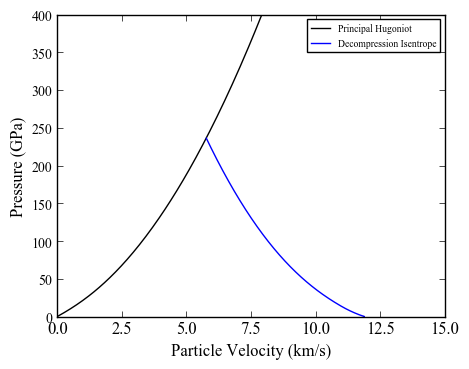

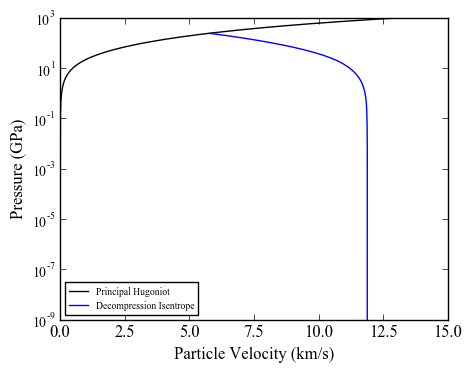

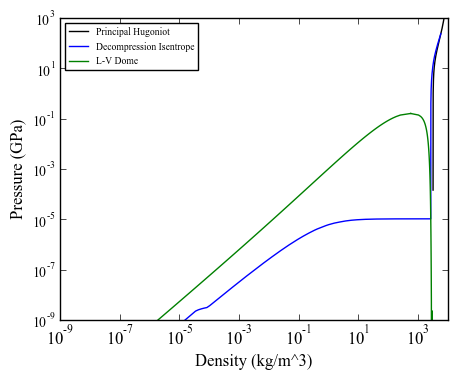

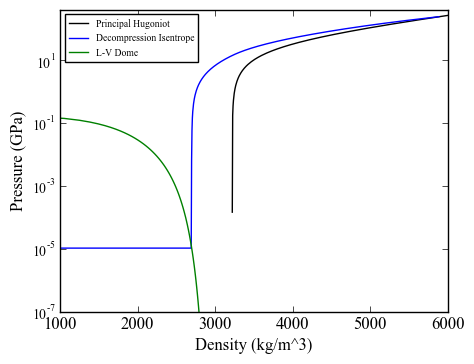

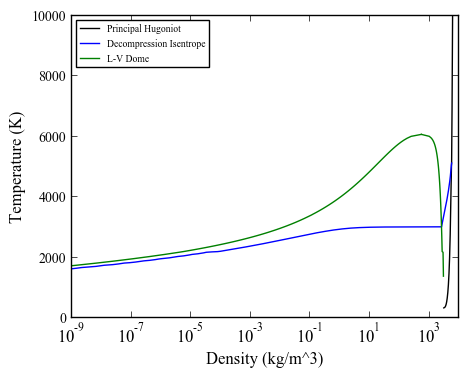

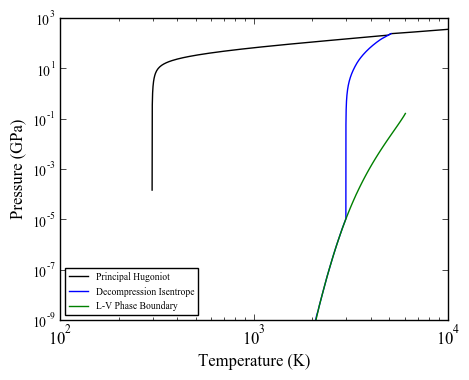

In [26]:
####EOS PLOTTING###
##P-UP###
plt.figure()
plt.plot(forsthug.up,forsthug.P,'-',color='black',label='Principal Hugoniot')
plt.plot(up_exp,forstEOS.P[S_ind,:P_ind+1],'-',color='blue',label='Decompression Isentrope')

#plt.semilogy()

plt.ylabel('Pressure (GPa)')
plt.xlabel('Particle Velocity (km/s)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

plt.xlim(0,15)
plt.ylim(0,400)
plt.savefig('P_Up_ExpansionVelocity.pdf', format='pdf', dpi=1000)

##P-UP###
plt.figure()
plt.plot(forsthug.up,forsthug.P,'-',color='black',label='Principal Hugoniot')
plt.plot(up_exp,forstEOS.P[S_ind,:P_ind+1],'-',color='blue',label='Decompression Isentrope')

plt.semilogy()

plt.ylabel('Pressure (GPa)')
plt.xlabel('Particle Velocity (km/s)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

plt.xlim(0,15)
plt.ylim(10**(-9),1000)
plt.savefig('P_Up_ExpansionVelocity_log.pdf', format='pdf', dpi=1000)

##P-rho###
plt.figure()
plt.plot(forsthug.rho,forsthug.P,'-',color='black',label='Principal Hugoniot')
plt.plot(forstEOS.rho[:P_ind+1],forstEOS.P[S_ind,:P_ind+1],'-',color='blue',label='Decompression Isentrope')
plt.plot(NewEOS.vc.rl*1000,NewEOS.vc.Pl,'-',color='green',label='L-V Dome')
plt.plot(NewEOS.vc.rv*1000,NewEOS.vc.Pv,'-',color='green')

plt.semilogy()
plt.semilogx()

plt.ylabel('Pressure (GPa)')
plt.xlabel('Density (kg/m^3)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)


#plt.xlim(0,20)
plt.ylim(10**(-9),1000)
plt.xlim(10**(-9),10000)
plt.savefig('P_Rho_decompression.pdf', format='pdf', dpi=1000)

##P-rho###
plt.figure()
plt.plot(forsthug.rho,forsthug.P,'-',color='black',label='Principal Hugoniot')
plt.plot(forstEOS.rho[:P_ind+1],forstEOS.P[S_ind,:P_ind+1],'-',color='blue',label='Decompression Isentrope')
plt.plot(NewEOS.vc.rl*1000,NewEOS.vc.Pl,'-',color='green',label='L-V Dome')
plt.plot(NewEOS.vc.rv*1000,NewEOS.vc.Pv,'-',color='green')

plt.semilogy()
#plt.semilogx()

plt.ylabel('Pressure (GPa)')
plt.xlabel('Density (kg/m^3)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

#plt.xlim(0,20)
plt.ylim(10**(-7),400)
plt.xlim(1000,6000)
plt.savefig('P_Rho_decompression_lin.pdf', format='pdf', dpi=1000)

##/t-rho###
plt.figure()
plt.plot(forsthug.rho,forsthug.T,'-',color='black',label='Principal Hugoniot')
plt.plot(forstEOS.rho[:P_ind+1],forstEOS.T[S_ind,:P_ind+1],'-',color='blue',label='Decompression Isentrope')
plt.plot(NewEOS.vc.rl*1000,NewEOS.vc.T,'-',color='green',label='L-V Dome')
plt.plot(NewEOS.vc.rv*1000,NewEOS.vc.T,'-',color='green')

#plt.semilogy()
plt.semilogx()


plt.ylabel('Temperature (K)')
plt.xlabel('Density (kg/m^3)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

#plt.xlim(0,20)
plt.ylim(0,10000)
plt.xlim(10**(-9),10000)
plt.savefig('T_Rho_decompression.pdf', format='pdf', dpi=1000)

##P-T###
plt.figure()
plt.plot(forsthug.T,forsthug.P,'-',color='black',label='Principal Hugoniot')
plt.plot(forstEOS.T[S_ind,:P_ind+1],forstEOS.P[S_ind,:P_ind+1],'-',color='blue',label='Decompression Isentrope')
plt.plot(NewEOS.vc.T,NewEOS.vc.Pv,'-',color='green',label='L-V Phase Boundary')

#NewEOS.vc.T

plt.semilogy()
plt.semilogx()

plt.ylabel('Pressure (GPa)')
plt.xlabel('Temperature (K)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

plt.xlim(100,10000)
plt.ylim(10**(-9),1000)
plt.savefig('T_P_decompression.pdf', format='pdf', dpi=1000)


plt.show()

Now using the calculated velocity, calculate a time profile of expansion, i.e. how long does it take to fill the new sphere at each pressure. This calculation is not perfect. The above riemann integral is really meant for planar expansion, and we are applying the results to a spherical expansion to obtain a semi-analytic time profile. In practice, this means that the particle velocity is too high, which is seen when compared to numerical simulations of spherical expansion. However, the particle velocity is on the same order of magnitude so the error is not expected to be large.

In [10]:
 ###################
#Given an initial radius sphere, how long does it take to expand to the "Final" radius?
#Take the triple point as the final pressure
Pi_max=max(min(np.where(tp*(10**(-9))>forstEOS.P[S_ind,:])))
Ptp_ind=Pi_max #Index of triple point

#Volume ratio is the density at the shocked pressure over the released TP pressure
VR=forstEOS.rho[P_ind]/forstEOS.rho[Ptp_ind]
#So final radius (assuming sphere v = 4/3 pi r^3)     vf/vi = rf^3/ri^3 so rf = ri * (vf/vi)^(1/3)
rf=ri*(VR**(1/3)) #km

#The way this calc works, is that the parcel is allowed to keep expanding until the final radius is met
# until the final radius is met, the parcel is inertially trapped integrate for time to volume at each
# density index so we get a cool time profile
#We use the above lines to scale the volume increase for each step.
rf_scaled = np.zeros(P_ind-Ptp_ind)
time_dt= np.zeros(P_ind-Ptp_ind)
total_time= np.zeros(P_ind-Ptp_ind)

#Fill in radius array
for i in range(P_ind-Ptp_ind):
    VR_scaled=forstEOS.rho[P_ind]/forstEOS.rho[P_ind-i]
    rf_scaled[i]=ri*(VR_scaled**(1/3))
#Calculate time to get to each step
for i in range(P_ind-Ptp_ind):
    if i == 0:
        time_dt[0] = (rf_scaled[i]-ri)/up_exp[P_ind-0]
    if i > 0:
        time_dt[i] = (rf_scaled[i]-rf_scaled[i-1])/up_exp[P_ind-i]
#Calc integrated time now

total_time[0] = time_dt[0]
for i in range(1,np.size(time_dt)):
    total_time[i] = total_time[i-1] + time_dt[i]


In [37]:
temp=min(min(np.where(forstEOS.rho[Ptp_ind:P_ind]>rho_2[0])))
temp2=temp+Ptp_ind-np.size(total_time)
print(temp,temp2,Ptp_ind,np.size(total_time))
print(total_time[np.size(total_time)+temp2])
print(total_time)

181 -116 138 435
0.057714141171752734
[0.00000000e+00 2.14748109e-04 4.28902311e-04 6.42482979e-04
 8.55510220e-04 1.06800006e-03 1.27997334e-03 1.49144802e-03
 1.70244030e-03 1.91297048e-03 2.12305458e-03 2.33270882e-03
 2.54195315e-03 2.75080217e-03 2.95927139e-03 3.16738089e-03
 3.37514480e-03 3.58257627e-03 3.78969639e-03 3.99652165e-03
 4.20305741e-03 4.40932856e-03 4.61535165e-03 4.82113032e-03
 5.02668954e-03 5.23204589e-03 5.43720192e-03 5.64218199e-03
 5.84700325e-03 6.05166925e-03 6.25619956e-03 6.46061329e-03
 6.66491782e-03 6.86912554e-03 7.07325302e-03 7.27731255e-03
 7.48131776e-03 7.68528220e-03 7.88921937e-03 8.09314274e-03
 8.29706565e-03 8.50100155e-03 8.70496368e-03 8.90896539e-03
 9.11301987e-03 9.31714041e-03 9.52134019e-03 9.72563240e-03
 9.93003025e-03 1.01345469e-02 1.03391955e-02 1.05439892e-02
 1.07489413e-02 1.09540649e-02 1.11593732e-02 1.13648795e-02
 1.15705969e-02 1.17765388e-02 1.19827184e-02 1.21891492e-02
 1.23958444e-02 1.26028175e-02 1.28100819e-02 1

In [11]:
#Calculate Mean free path of photon paths in a cloud of silicates droplets with vapor in between. See Lock et al. 2018
# for a derivation of the mean free path through a cloud of opaque droplets with non-absorbing vapor

#MFP=(4/6)*(condensate size)*(volume of bulk/volume of liquid)      or
#MFP=(4/6)*(condensate size)*(rho_l/rho_bulk) 




#MFP depends on mean size of droplets, which we don't know, so lots of cases
#Diameter of example condensates
d1=10**(-6) #meters
d2=10**(-5) #meters
d3=10**(-4) #meters
d4=10**(-3) #meters
d5=10**(-2) #meters
d6=10**(-1) #meters

#Make an interpolator for L-V liquid side density
rho_s_lv=interpolate.interp1d(NewEOS.vc.Pl*(10**9),(NewEOS.vc.rl*1000))

#This calculation assumes that SCF also behaves like the liquid - reflectivity measurements
#in shock experiments (where the shocked material is supercritical) seem to confirm this.
# decompression to the L-V dome is almost instantaneous as well so its probably not a huge deal

#So we have to deal with this in two steps. Using decompression pressure index, calculate MFP down to the edge
# of the dome. Volume of bulk and liquid are the same for this part, therefore the MFP is the condensate size. 
#After the intersection then MFP can grow. 

#        Slv_ind=Si_max
#        lvFlag=1 #Set flag for later
#First set up MFP arrays as 
#This could probably be done as a single array

MFP1=np.zeros(P_ind-Ptp_ind)
MFP2=np.zeros(P_ind-Ptp_ind)
MFP3=np.zeros(P_ind-Ptp_ind)
MFP4=np.zeros(P_ind-Ptp_ind)
MFP5=np.zeros(P_ind-Ptp_ind)
MFP6=np.zeros(P_ind-Ptp_ind)

if lvFlag ==0: #Liquid side of CP
    for i in range(P_ind-Ptp_ind):
        if forstEOS.P[S_ind,P_ind - i] > NewEOS.vc.Pl[Slv_ind]: #Down to the dome
            MFP1[i]=(4/6)*(d1)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP2[i]=(4/6)*(d2)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP3[i]=(4/6)*(d3)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP4[i]=(4/6)*(d4)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP5[i]=(4/6)*(d5)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP6[i]=(4/6)*(d6)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
        if forstEOS.P[S_ind,P_ind - i] < NewEOS.vc.Pl[Slv_ind]: #From the dome to the TP
            MFP1[i]=(4/6)*(d1)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP2[i]=(4/6)*(d2)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP3[i]=(4/6)*(d3)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP4[i]=(4/6)*(d4)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP5[i]=(4/6)*(d5)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP6[i]=(4/6)*(d6)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]   
if lvFlag ==1: # vapor side of CP
    for i in range(P_ind-Ptp_ind): 
        if forstEOS.P[S_ind,P_ind - i] > NewEOS.vc.Pv[Slv_ind]:
            MFP1[i]=(4/6)*(d1)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP2[i]=(4/6)*(d2)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP3[i]=(4/6)*(d3)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP4[i]=(4/6)*(d4)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP5[i]=(4/6)*(d5)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP6[i]=(4/6)*(d6)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
        if forstEOS.P[S_ind,P_ind - i] < NewEOS.vc.Pv[Slv_ind]:
            MFP1[i]=(4/6)*(d1)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP2[i]=(4/6)*(d2)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP3[i]=(4/6)*(d3)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP4[i]=(4/6)*(d4)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP5[i]=(4/6)*(d5)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP6[i]=(4/6)*(d6)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]     
    


In [12]:
#print(NewEOS.vc.Pl)
#print(NewEOS.vc.Pv)
#print(rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9)))
#rho_s(forstEOS.P[S_ind,Ptp_ind:P_ind]*(10**9))
#print(MFP1)

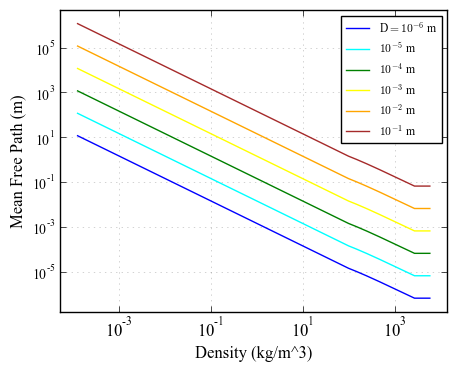

In [13]:
#Plot MFP stuff
#At 
plt.figure()
plt.rc('grid',color='black', linestyle=':', linewidth=0.5,alpha=0.25)
plt.plot(forstEOS.rho[Ptp_ind:P_ind],MFP1[::-1],label='D$=10^{-6}$ m',color='blue')
plt.plot(forstEOS.rho[Ptp_ind:P_ind],MFP2[::-1],label='$10^{-5}$ m',color='cyan')
plt.plot(forstEOS.rho[Ptp_ind:P_ind],MFP3[::-1],label='$10^{-4}$ m',color='green')
plt.plot(forstEOS.rho[Ptp_ind:P_ind],MFP4[::-1],label='$10^{-3}$ m',color='yellow')
plt.plot(forstEOS.rho[Ptp_ind:P_ind],MFP5[::-1],label='$10^{-2}$ m',color='orange')
plt.plot(forstEOS.rho[Ptp_ind:P_ind],MFP6[::-1],label='$10^{-1}$ m',color='brown')
plt.xlabel('Density (kg/m^3)')
plt.ylabel('Mean Free Path (m)')
plt.semilogx()
plt.semilogy()
#xlocs, xlabels=plt.xticks()
#plt.xticks(xlocs[::3])
#ylocs, ylabels=plt.yticks()
#plt.yticks(ylocs[::3])
plt.legend(loc='upper right',fontsize='small')
plt.grid()
plt.savefig('MFP_Vf.pdf', format='pdf', dpi=1000)

In [14]:
#####Radiative cooling####
# we have total energy of the vapor plume from aneos
#Need to input some initial volume/mass
#t_radiative = E/L



FileNotFoundError: [Errno 2] No such file or directory: 'MFP/R_Time.pdf'

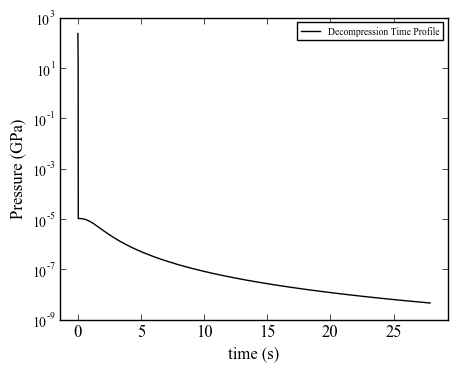

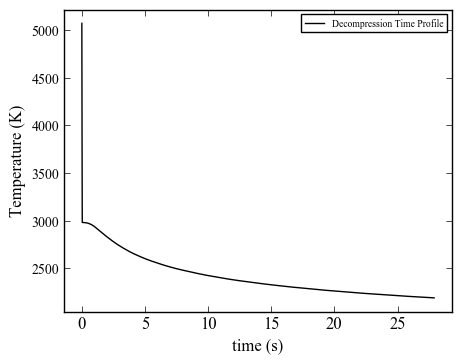

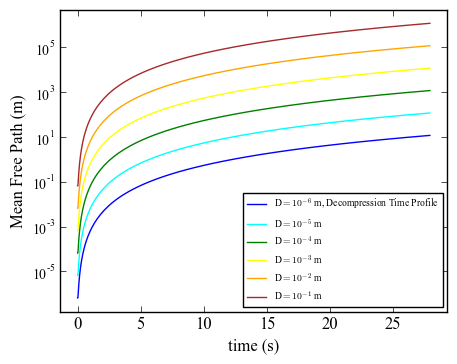

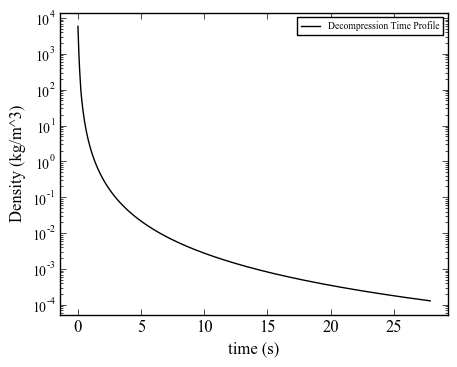

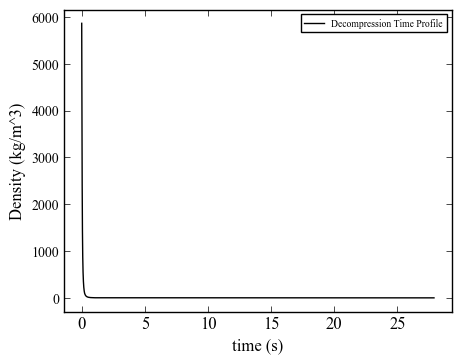

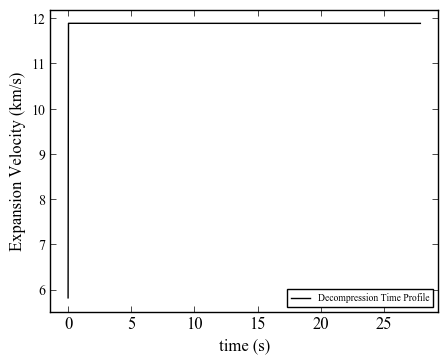

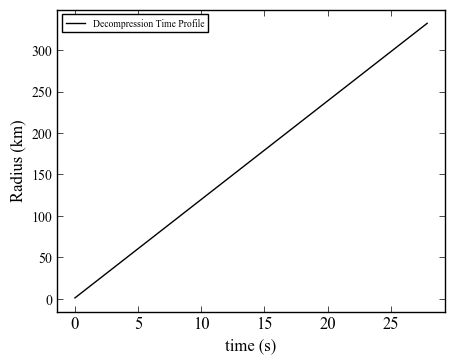

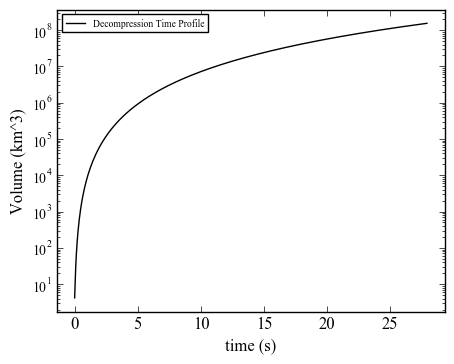

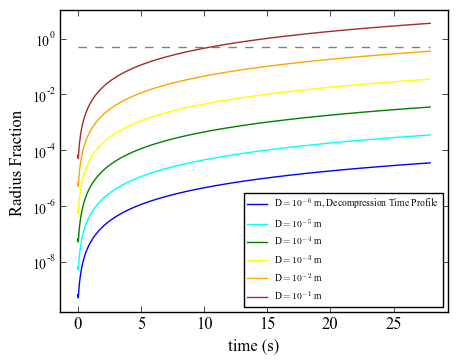

In [15]:
#Time profile plots
##P-time###
plt.figure()
plt.plot(total_time[::-1],forstEOS.P[S_ind,Ptp_ind:P_ind],'-',color='black',label='Decompression Time Profile')


plt.semilogy()

plt.ylabel('Pressure (GPa)')
plt.xlabel('time (s)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

#plt.xlim(0,15000)
plt.ylim(10**(-9),1000)
plt.savefig('P_Time.pdf', format='pdf', dpi=1000)

##T-time###
plt.figure()
plt.plot(total_time[::-1],forstEOS.T[S_ind,Ptp_ind:P_ind],'-',color='black',label='Decompression Time Profile')


#plt.semilogy()

plt.ylabel('Temperature (K)')
plt.xlabel('time (s)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)
plt.savefig('T_Time.pdf', format='pdf', dpi=1000)

#plt.xlim(0,15000)
#plt.ylim(10**(-9),1000)

##MFP-time###
plt.figure()
plt.plot(total_time[::-1],MFP1[::-1],'-',color='blue',label='D$=10^{-6}$ m, Decompression Time Profile')
plt.plot(total_time[::-1],MFP2[::-1],'-',color='cyan',label='D$=10^{-5}$ m')
plt.plot(total_time[::-1],MFP3[::-1],'-',color='green',label='D$=10^{-4}$ m')
plt.plot(total_time[::-1],MFP4[::-1],'-',color='yellow',label='D$=10^{-3}$ m')
plt.plot(total_time[::-1],MFP5[::-1],'-',color='orange',label='D$=10^{-2}$ m')
plt.plot(total_time[::-1],MFP6[::-1],'-',color='brown',label='D$=10^{-1}$ m')
plt.semilogy()

plt.ylabel('Mean Free Path (m)')
plt.xlabel('time (s)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)
plt.savefig('MFP_Time.pdf', format='pdf', dpi=1000)

##rho-time###
plt.figure()
plt.plot(total_time[::-1],forstEOS.rho[Ptp_ind:P_ind],'-',color='black',label='Decompression Time Profile')
plt.semilogy()

plt.ylabel('Density (kg/m^3)')
plt.xlabel('time (s)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)
plt.savefig('rho_Time_log.pdf', format='pdf', dpi=1000)

#plt.xlim(0,15000)
#plt.ylim(0.0001,1000)
#Rho - tim non log
plt.figure()
plt.plot(total_time[::-1],forstEOS.rho[Ptp_ind:P_ind],'-',color='black',label='Decompression Time Profile')
#plt.semilogy()

plt.ylabel('Density (kg/m^3)')
plt.xlabel('time (s)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)
plt.savefig('rho_Time.pdf', format='pdf', dpi=1000)

#plt.xlim(0,15000)
#plt.ylim(0.0001,1000)

##up-time###
plt.figure()
plt.plot(total_time[::-1],up_exp[Ptp_ind:P_ind],'-',color='black',label='Decompression Time Profile')
#plt.semilogy()

plt.ylabel('Expansion Velocity (km/s)')
plt.xlabel('time (s)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)
plt.savefig('Vexp_Time.pdf', format='pdf', dpi=1000)

#plt.xlim(0,15000)
#plt.ylim(0.0001,1000)

##radius-time###
plt.figure()
plt.plot(total_time[:],rf_scaled[:],'-',color='black',label='Decompression Time Profile')
#plt.semilogy()

plt.ylabel('Radius (km)')
plt.xlabel('time (s)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)
plt.savefig('R_Time.pdf', format='pdf', dpi=1000)

#plt.xlim(0,15000)
#plt.ylim(0.0001,1000)
#Volume versus time
plt.figure()
plt.plot(total_time[:],(4/3)*np.pi*(rf_scaled[:]**3),'-',color='black',label='Decompression Time Profile')
plt.semilogy()

plt.ylabel('Volume (km^3)')
plt.xlabel('time (s)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)
plt.savefig('V_Time.pdf', format='pdf', dpi=1000)

#plt.xlim(0,15000)
#plt.ylim(0.0001,1000)

#MFP over current radius versus time
plt.figure()
plt.plot(total_time[:],MFP1[:]/(rf_scaled[:]*1000),'-',color='blue',label='D$=10^{-6}$ m, Decompression Time Profile')
plt.plot(total_time[:],MFP2[:]/(rf_scaled[:]*1000),'-',color='cyan',label='D$=10^{-5}$ m')
plt.plot(total_time[:],MFP3[:]/(rf_scaled[:]*1000),'-',color='green',label='D$=10^{-4}$ m')
plt.plot(total_time[:],MFP4[:]/(rf_scaled[:]*1000),'-',color='yellow',label='D$=10^{-3}$ m')
plt.plot(total_time[:],MFP5[:]/(rf_scaled[:]*1000),'-',color='orange',label='D$=10^{-2}$ m')
plt.plot(total_time[:],MFP6[:]/(rf_scaled[:]*1000),'-',color='brown',label='D$=10^{-1}$ m')
plt.hlines(0.5, total_time[0], total_time[-1], colors='black', linestyles='dashed',alpha=0.5)

#plt.plot(total_time[::-1],MFP4[:],'-',color='yellow',label='D$=10^{-3}$ m')
plt.semilogy()

plt.ylabel('Radius Fraction ')
plt.xlabel('time (s)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)
plt.savefig('MFP/R_Time.pdf', format='pdf', dpi=1000)


Now that we have MFP and time profiles, calculate vapor fractions over the decompression. This calculation does not index to the time profiles, it is to give intuition for how the vapor fraction influences volume expansion of the vapor plume, therefore it is normalized to the un-shocked volume.

In [16]:
#Set up some entropies to calculate vapor fractions over. 
entropy1=3305
entropy2=4000 
entropy3=5000 #
entropy4=6000 
entropy5=7000 

#eos index for given entropy
#First entropy index
Si_min=min(min(np.where(entropy1<forstEOS.S)))
Si_max=max(min(np.where(entropy1>forstEOS.S)))
temp1=abs(forstEOS.S[Si_min]-entropy1)
temp2=abs(forstEOS.S[Si_max]-entropy1)
S1_ind=Si_min #Set index to first one
if temp1 > temp2: #if temp2 is smaller use that one instead
    S1_ind=Si_max

#Second entropy index
Si_min=min(min(np.where(entropy2<forstEOS.S)))
Si_max=max(min(np.where(entropy2>forstEOS.S)))
temp1=abs(forstEOS.S[Si_min]-entropy2)
temp2=abs(forstEOS.S[Si_max]-entropy2)
S2_ind=Si_min #Set index to first one
if temp1 > temp2: #if temp2 is smaller use that one instead
    S2_ind=Si_max
    
#third entropy index
Si_min=min(min(np.where(entropy3<forstEOS.S)))
Si_max=max(min(np.where(entropy3>forstEOS.S)))
temp1=abs(forstEOS.S[Si_min]-entropy3)
temp2=abs(forstEOS.S[Si_max]-entropy3)
S3_ind=Si_min #Set index to first one
if temp1 > temp2: #if temp2 is smaller use that one instead
    S3_ind=Si_max    
    
#fourth entropy index
Si_min=min(min(np.where(entropy4<forstEOS.S)))
Si_max=max(min(np.where(entropy4>forstEOS.S)))
temp1=abs(forstEOS.S[Si_min]-entropy4)
temp2=abs(forstEOS.S[Si_max]-entropy4)
S4_ind=Si_min #Set index to first one
if temp1 > temp2: #if temp2 is smaller use that one instead
    S4_ind=Si_max    
    
#fifth entropy index
Si_min=min(min(np.where(entropy5<forstEOS.S)))
Si_max=max(min(np.where(entropy5>forstEOS.S)))
temp1=abs(forstEOS.S[Si_min]-entropy5)
temp2=abs(forstEOS.S[Si_max]-entropy5)
S5_ind=Si_min #Set index to first one
if temp1 > temp2: #if temp2 is smaller use that one instead
    S5_ind=Si_max        
 

In [17]:
#Set up a quick lever rule function
def lever_fraction(Sm,S1,S2):
    result=(S2-Sm)/(S2-S1) #liquid fraction output
    return result

In [30]:
#Set up interpolators for entropy in the vapor dome based on pressure
S_l=interpolate.interp1d(NewEOS.vc.Pl*(10**9),(NewEOS.vc.Sl*1000000))
S_v=interpolate.interp1d(NewEOS.vc.Pv*(10**9),(NewEOS.vc.Sv*1000000))

#And the other way
P_l=interpolate.interp1d((NewEOS.vc.Sl*1000000),NewEOS.vc.Pl*(10**9))
P_v=interpolate.interp1d((NewEOS.vc.Sv*1000000),NewEOS.vc.Pv*(10**9))

#And for rho based on the isentrope pressures for each isentrope
rho1=interpolate.interp1d(forstEOS.P[S1_ind,:]*(10**9),(forstEOS.rho[:]))
rho2=interpolate.interp1d(forstEOS.P[S2_ind,:]*(10**9),(forstEOS.rho[:]))
rho3=interpolate.interp1d(forstEOS.P[S3_ind,:]*(10**9),(forstEOS.rho[:]))
rho4=interpolate.interp1d(forstEOS.P[S4_ind,:]*(10**9),(forstEOS.rho[:]))
rho5=interpolate.interp1d(forstEOS.P[S5_ind,:]*(10**9),(forstEOS.rho[:]))

#Set up starting pressures and pressure arrays
Pstart1=P_l(entropy1)
Par1=np.linspace(Pstart1,5.2,size)
Pstart2=P_l(entropy2)
Par2=np.linspace(Pstart2,5.2,size)
Pstart3=P_l(entropy3)
Par3=np.linspace(Pstart3,5.2,size)
Pstart4=P_l(entropy4)
Par4=np.linspace(Pstart4,5.2,size)
Pstart5=P_v(entropy5)
Par5=np.linspace(Pstart5,5.2,size)

#Grab all the dome entropies relevant to P arrays,
S1_l=S_l(Par1)
S1_v=S_v(Par1)

S2_l=S_l(Par2)
S2_v=S_v(Par2)

S3_l=S_l(Par3)
S3_v=S_v(Par3)

S4_l=S_l(Par4)
S4_v=S_v(Par4)

S5_l=S_l(Par5)
S5_v=S_v(Par5)

#Grab all densities now
rho_1=rho1(Par1)
rho_2=rho2(Par2)
rho_3=rho3(Par3)
rho_4=rho4(Par4)
rho_5=rho5(Par5)
print(rho_2[0])

2690.000712833591


In [19]:
#Lever rule to get vapor fractions at each pressure

v_fr1=1-lever_fraction(entropy1,S1_l,S1_v) #Get vapor fraction, from level rule
v_fr2=1-lever_fraction(entropy2,S2_l,S2_v)
v_fr3=1-lever_fraction(entropy3,S3_l,S3_v)
v_fr4=1-lever_fraction(entropy4,S4_l,S4_v)
v_fr5=1-lever_fraction(entropy5,S5_l,S5_v)

In [20]:
#Set up constant pressure volume of vapor fraction, 1 bar and TP

#Quick interpolators, this time for density on the dome
rhodome_l=interpolate.interp1d(NewEOS.vc.Pl*(10**9),(NewEOS.vc.rl*1000))
rhodome_v=interpolate.interp1d(NewEOS.vc.Pl*(10**9),(NewEOS.vc.rv*1000))

S_at_st=S_l(100000)
S_at_end=S_v(100000)#Get entropy on dome
rho_at_st=rhodome_l(100000)
rho_at_end=rhodome_v(100000) #get rho on the dome at pressure
S_at=np.linspace(S_at_st,S_at_end,size) #Set up entropy array
v_fr_at=1-lever_fraction(S_at,S_at_st,S_at_end) #Calc vapor frac
V_final_at=(1/rho_at_end)*v_fr_at + 1/(rho_at_st)*(1-v_fr_at) #Calc volume frac


S_tp_st=S_l(5.2)
S_tp_end=S_v(5.2)
rho_tp_st=rhodome_l(5.2)
rho_tp_end=rhodome_v(5.2)
S_tp=np.linspace(S_tp_st,S_tp_end,size)
v_fr_tp=1-lever_fraction(S_tp,S_tp_st,S_tp_end)
V_final_tp=(1/rho_tp_end)*v_fr_tp + 1/(rho_tp_st)*(1-v_fr_tp) #Calc volume frac



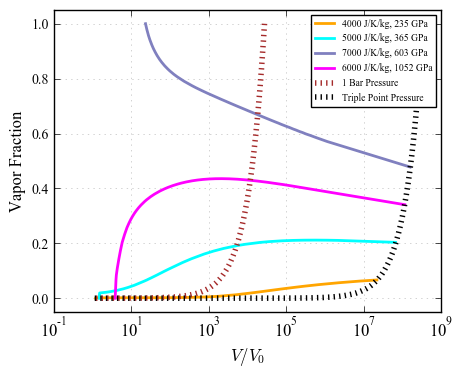

In [21]:
#Plot the vapor fractions!
plt.figure()
plt.rc('grid',color='black', linestyle=':', linewidth=0.5,alpha=0.25)
plt.plot((R0REF*1000)/rho_2,v_fr2,label='{} J/K/kg, 235 GPa'.format(entropy2), color="orange",linewidth=2)
plt.plot((R0REF*1000)/rho_3,v_fr3,label='{} J/K/kg, 365 GPa'.format(entropy3), color="cyan",linewidth=2)
plt.plot((R0REF*1000)/rho_5,v_fr5,label='{} J/K/kg, 603 GPa'.format(entropy5), color=(0.5,0.5,.75),linewidth=2)
plt.plot((R0REF*1000)/rho_4,v_fr4,label='{} J/K/kg, 1052 GPa'.format(entropy4), color="magenta",linewidth=2)
plt.plot(V_final_at/(1/(R0REF*1000)),v_fr_at, color='brown', linestyle=":", linewidth=4,label='1 Bar Pressure',)
plt.plot(V_final_tp/(1/(R0REF*1000)),v_fr_tp,label='Triple Point Pressure', color='black', linestyle=":", linewidth=4)
plt.xlabel('$V/V_0$')
plt.ylabel('Vapor Fraction')
plt.xlim(10**-1,10**9)
plt.semilogx()
#xlocs, xlabels=plt.xticks()
#plt.xticks(xlocs[::3])
#ylocs, ylabels=plt.yticks()
#plt.yticks(ylocs[::1])
plt.legend(loc='upper right', fontsize='x-small',numpoints=1,scatterpoints=1 )
plt.grid()
plt.savefig('VF_dV.pdf', format='pdf', dpi=1000)

In [22]:
#Set A constant Stefan Boltzmann

sigma=5.670374419*10**(-8) #W⋅m−2⋅K−4
#Luminosity is given by stefan boltzaann
L=4 * np.pi * sigma*((rf_scaled[::-1]*1000)**2) * forstEOS.T[S_ind,Ptp_ind:P_ind] **4 # watts

#Energy
#forstEOS.U[S_ind,P_ind]*1.E-4
#Total energy of the initial object Specific energy times the total mass
#Total mass is density times volume
#Use the initial radius to get 
Volume= (4/3) * np.pi *(ri*1000)**3
#So mass is
Mass = Volume* forstEOS.rho[P_ind]
#So total energy - this is energy at the shock state. How long to cool to original energy?
Tot_U=Mass*forstEOS.U[S_ind,P_ind]*1.E-4


#Original energy 


orig_U=forsthug.U[0]*10**6
print(orig_U)

#
#print(Mass)
#print(forstEOS.rho[P_ind])

#Energy to cool is energy to stp, which is a good enough estimation
#Assuming perfect radiative cooling (not realistic) a simple time
# of cooling is just E/L, leaving units of seconds

Time_cooling=(Tot_U-orig_U)/L
print(orig_U,Time_cooling)




71803.7
71803.7 [2.27067189e+02 2.55568470e+02 2.87305185e+02 3.23161551e+02
 3.63261537e+02 4.08448922e+02 4.58987070e+02 5.16020050e+02
 5.79820487e+02 6.51544394e+02 7.31623548e+02 8.22883005e+02
 9.24544925e+02 1.03757507e+03 1.16509010e+03 1.30768172e+03
 1.46745684e+03 1.64763100e+03 1.85156251e+03 2.07894429e+03
 2.33267613e+03 2.61728481e+03 2.93805310e+03 3.29940286e+03
 3.70547941e+03 4.16163557e+03 4.67652164e+03 5.25392215e+03
 5.90275384e+03 6.63409214e+03 7.46899618e+03 8.40997204e+03
 9.47189436e+03 1.06769438e+04 1.20488990e+04 1.36108534e+04
 1.54037362e+04 1.74325390e+04 1.97396715e+04 2.24150902e+04
 2.54761546e+04 2.90041274e+04 3.30610288e+04 3.77397958e+04
 4.31436208e+04 4.93932557e+04 5.66453157e+04 6.50439392e+04
 7.47673275e+04 8.60284318e+04 9.90725423e+04 1.14182435e+05
 1.31681709e+05 1.51949296e+05 1.75420619e+05 2.02598740e+05
 2.34065350e+05 2.70493181e+05 3.12660422e+05 3.61467283e+05
 4.17955273e+05 4.83329322e+05 5.60624921e+05 6.32869762e+05
 7.01210

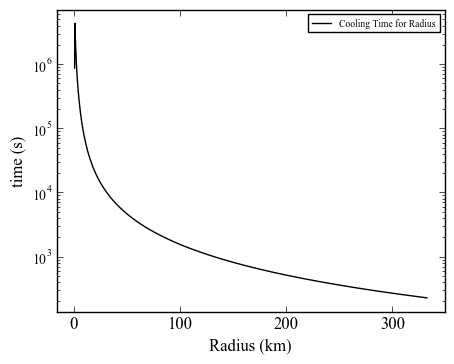

In [23]:
#Plot cooling time scale from total luminosity
plt.figure()
plt.plot(rf_scaled[:],Time_cooling[::-1],'-',color='black',label='Cooling Time for Radius')
plt.semilogy()

plt.xlabel('Radius (km)')
plt.ylabel('time (s)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)
plt.savefig('Cooling_Time_at_radius.pdf', format='pdf', dpi=1000)
